In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch

# torch.set_float32_matmul_precision('medium')
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import TQDMProgressBar
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchmetrics import Accuracy
from torchvision import transforms
from tqdm.auto import tqdm

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Dataset

In [2]:
data_dir = "flowers"

classes = os.listdir(data_dir)
class_cnt = {}
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    class_cnt[class_name] = len(os.listdir(class_path))

print("Classes:", class_cnt)

Classes: {'sunflower': 734, 'rose': 784, 'daisy': 769, 'dandelion': 1055, 'tulip': 984}


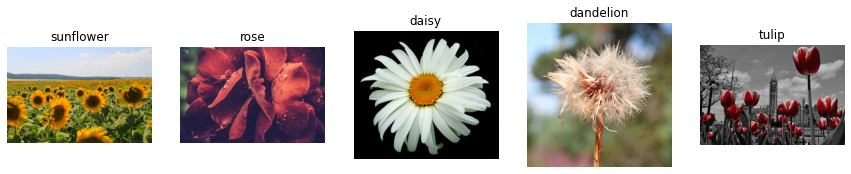

In [3]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    image_name = os.listdir(class_path)[0]
    img = Image.open(os.path.join(class_path, image_name))
    axes[i].imshow(img)
    axes[i].set_title(class_name)
    axes[i].axis("off")

In [4]:
sizes = []
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_path):
        if os.path.splitext(image_name)[1].lower() == ".jpg":
            img = Image.open(os.path.join(class_path, image_name))
            sizes.append(img.size)

print("Sample sizes:", sizes[:10])

Sample sizes: [(500, 334), (500, 375), (166, 240), (500, 400), (320, 240), (320, 240), (500, 333), (180, 240), (500, 333), (500, 332)]


In [5]:
class FlowersDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []

        self.classes = os.listdir(data_dir)
        for index, class_name in enumerate(classes):
            class_path = os.path.join(data_dir, class_name)
            for image_name in os.listdir(class_path):
                if os.path.splitext(image_name)[1].lower() == ".jpg":
                    self.images.append(os.path.join(class_path, image_name))
                    self.labels.append(index)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

    def __len__(self):
        return len(self.images)

Model

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=1568, out_features=num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [7]:
class SimpleModel(pl.LightningModule):
    def __init__(self, net, loss_function, lr):
        super().__init__()
        self.net = net
        self.loss_function = loss_function
        self.lr = lr
        self.history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
        self.accuracy = Accuracy(task="multiclass", num_classes=len(classes))

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, _):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)
        acc = self.accuracy(torch.argmax(outputs, dim=1), labels)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, _):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)
        acc = self.accuracy(torch.argmax(outputs, dim=1), labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_train_epoch_end(self):
        self.history["train_loss"].append(self.trainer.logged_metrics.get("train_loss"))
        self.history["train_acc"].append(self.trainer.logged_metrics.get("train_acc"))

    def on_validation_epoch_end(self):
        self.history["val_loss"].append(self.trainer.logged_metrics.get("val_loss"))
        self.history["val_acc"].append(self.trainer.logged_metrics.get("val_acc"))

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

Transformations

In [8]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
])

Learning

In [9]:
class LitProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm(disable=True)
        bar.close()
        return bar

In [10]:
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

num_epochs = 10
batch_size = 64
k_folds = 5
num_classes = len(classes)
loss_function = nn.CrossEntropyLoss()
lr = 0.0001


dataset = FlowersDataset(data_dir="flowers", transform=transform)

history = []
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f"Fold: {fold}")
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_ids), num_workers=9)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_ids), num_workers=9)

    net = SimpleCNN(num_classes)
    model = SimpleModel(net, loss_function, lr)
    trainer = Trainer(max_epochs=num_epochs, callbacks=[LitProgressBar()], num_sanity_val_steps=0)
    trainer.fit(model, train_loader, val_loader)
    history.append(model.history)

Fold: 0


Training: |          | 0/? [00:00<?, ?it/s]

Fold: 1


Training: |          | 0/? [00:00<?, ?it/s]

Fold: 2


Training: |          | 0/? [00:00<?, ?it/s]

Fold: 3


Training: |          | 0/? [00:00<?, ?it/s]

Fold: 4


Training: |          | 0/? [00:00<?, ?it/s]

Mean validation accuracy: 0.5411


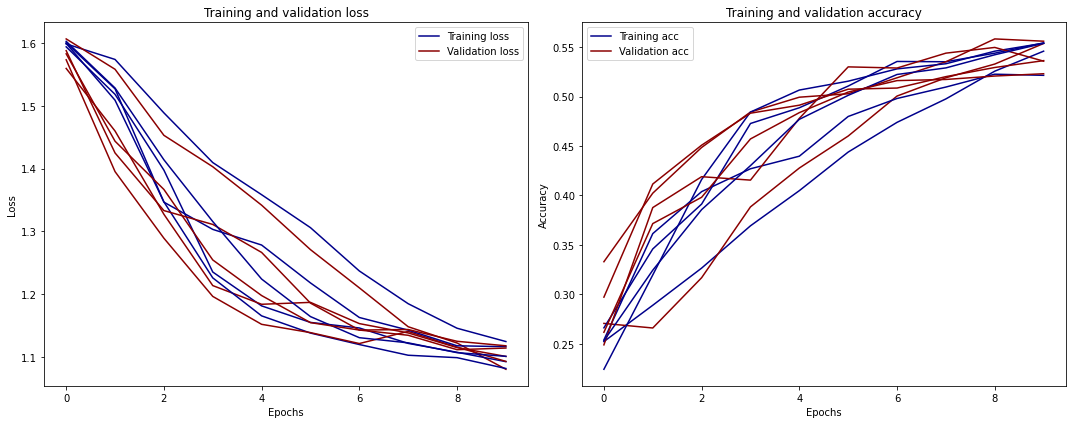

In [11]:
print(f"Mean validation accuracy: {np.mean([history[i]['val_acc'][-1].item() for i in range(k_folds)]):.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
for fold in range(k_folds):
    loss = [t.item() for t in history[fold]['train_loss']]
    val_loss = [t.item() for t in history[fold]['val_loss']]
    epochs = range(len(loss))
    ax1.plot(epochs, loss, label='Training loss' if fold == 0 else None, color="darkblue")
    ax1.plot(epochs, val_loss, label='Validation loss' if fold == 0 else None, color="darkred")

ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

for fold in range(k_folds):
    acc = [t.item() for t in history[fold]['train_acc']]
    val_acc = [t.item() for t in history[fold]['val_acc']]
    epochs = range(len(acc))
    ax2.plot(epochs, acc, label='Training acc' if fold == 0 else None, color="darkblue")
    ax2.plot(epochs, val_acc, label='Validation acc' if fold == 0 else None, color="darkred")

ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()